In [1]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from kmodes.kprototypes import KPrototypes
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings('ignore')

# Thiết lập style cho các biểu đồ
sns.set_style("whitegrid")  # Using direct seaborn styling instead of plt.style.use
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

file_path = '../dataset/train_segmented.csv'
df = pd.read_csv(file_path)

# Create a copy of the original dataframe for later reference
df_original = df.copy()

In [2]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Các cột số & phân loại
numerical_cols = ['case_thickness', 'case_diameter', 'water_resistance']
onehot_cols = ['gender', 'movement', 'watch_style']
categorical_cols = ['case_material', 'band_material', 'case_back', 'bezel_material', 
                    'brand', 'crystal', 'hands', 'dial_markers']
k_categorical_cols = onehot_cols + categorical_cols

all_categorical_cols = numerical_cols + categorical_cols


# Scale dữ liệu số
scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Category pooling (gộp nhóm các giá trị hiếm)
def pool_categories(series, threshold=0.01):
    value_counts = series.value_counts(normalize=True)
    rare = value_counts[value_counts < threshold].index
    return series.apply(lambda x: 'Other' if x in rare else x)

# Gộp giá trị hiếm
df_pooled = df.copy()
high_card_cols = [col for col in categorical_cols if df[col].nunique() > 50]
for col in high_card_cols:
    df_pooled[col] = pool_categories(df[col])

# Label Encoding
df_kproto_improved = df_pooled.copy()
label_encoders_improved = {}
for col in k_categorical_cols:
    le = LabelEncoder()
    df_kproto_improved[col] = le.fit_transform(df_kproto_improved[col])
    label_encoders_improved[col] = le

df_kproto = df_kproto_improved.copy()

print("\n=== KIỂM TRA DỮ LIỆU SAU KHI TIỀN XỬ LÝ CẢI TIẾN ===")
print("Dữ liệu cho K-Prototypes với category pooling:")
print(df_kproto.head())



=== KIỂM TRA DỮ LIỆU SAU KHI TIỀN XỬ LÝ CẢI TIẾN ===
Dữ liệu cho K-Prototypes với category pooling:
   case_material  band_material  case_back  bezel_material  brand  gender  \
0              7              6         45               1      1       2   
1              7              9         28               9      8       0   
2              7              8         28               9     29       0   
3              7              6         28               8     20       2   
4              7              9         28               9     16       0   

   movement  watch_style  case_thickness  crystal  hands  dial_markers  \
0         0            4        0.100313        4     12             4   
1         3            7        0.111285        1     13             4   
2         3            7        0.147335        4     12             4   
3         3            4        0.086207        3     13             6   
4         3            0        0.137871        3     13          

Đang đánh giá số cụm tối ưu bằng nhiều phương pháp...
Categorical indices: [5, 6, 7, 0, 1, 2, 3, 4, 9, 10, 11]
Đánh giá với k=2...
k=2, Silhouette=0.1844, Davies-Bouldin=1.9110, Calinski-Harabasz=1140.7167
Đánh giá với k=3...
k=3, Silhouette=0.0940, Davies-Bouldin=2.8243, Calinski-Harabasz=837.0246
Đánh giá với k=4...
k=4, Silhouette=0.0751, Davies-Bouldin=3.3327, Calinski-Harabasz=605.7195
Đánh giá với k=5...
k=5, Silhouette=0.0554, Davies-Bouldin=3.5967, Calinski-Harabasz=506.9645
Đánh giá với k=6...
k=6, Silhouette=0.0547, Davies-Bouldin=3.4965, Calinski-Harabasz=441.5368
Đánh giá với k=7...
k=7, Silhouette=0.0502, Davies-Bouldin=3.7200, Calinski-Harabasz=376.5369
Đánh giá với k=8...
k=8, Silhouette=0.0505, Davies-Bouldin=3.6359, Calinski-Harabasz=342.3193
Đánh giá với k=9...
k=9, Silhouette=0.0469, Davies-Bouldin=3.7375, Calinski-Harabasz=313.7858
Đánh giá với k=10...
k=10, Silhouette=0.0501, Davies-Bouldin=3.5541, Calinski-Harabasz=291.0843
Đánh giá với k=11...
k=11, Silhouette=0.

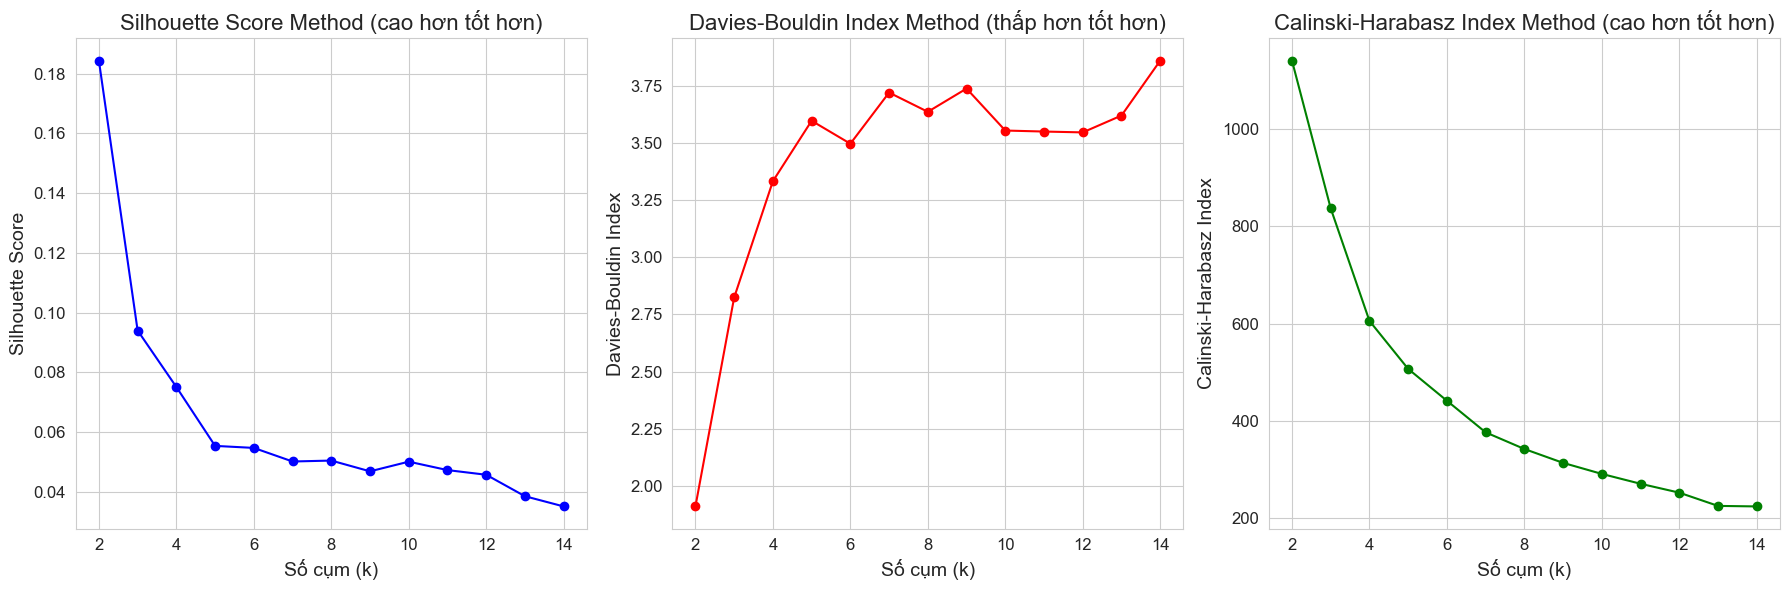

Số cụm tối ưu theo Silhouette Score: 2
Số cụm tối ưu theo Davies-Bouldin Index: 2
Số cụm tối ưu theo Calinski-Harabasz Index: 2

Kết quả bỏ phiếu: [2, 2, 2]
Số cụm tối ưu được đề xuất: 2

Số cụm tối ưu K-Prototypes đã được cập nhật thành: 2


In [5]:
# Thêm các phương pháp tìm k tối ưu
print("Đang đánh giá số cụm tối ưu bằng nhiều phương pháp...")

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np

# Chuẩn bị danh sách để lưu các giá trị metric
silhouette_scores = []
db_scores = []
ch_scores = []
K = range(2, 15)

# Tạo bản sao dữ liệu để mã hóa cho các thuật toán metric
# Chuyển đổi tất cả cột sang dạng số (cần thiết cho các metric)
from sklearn.preprocessing import OneHotEncoder

# Xác định cột số và cột phân loại
numeric_cols = [col for col in df_kproto.columns if col not in k_categorical_cols]

# Xác định indices của các cột phân loại
categorical_indices = [df_kproto.columns.get_loc(col) for col in k_categorical_cols]
print(f"Categorical indices: {categorical_indices}")

# One-hot encoding cho cột phân loại
encoder = OneHotEncoder(sparse_output=False, drop='first')
categorical_encoded = encoder.fit_transform(df_kproto[k_categorical_cols])
categorical_col_names = encoder.get_feature_names_out(k_categorical_cols)

# Kết hợp cột số và cột đã mã hóa
df_encoded = pd.DataFrame(df_kproto[numeric_cols].values, columns=numeric_cols)
df_encoded = pd.concat([
    df_encoded, 
    pd.DataFrame(categorical_encoded, columns=categorical_col_names)
], axis=1)

# Tính toán các metric cho các giá trị k khác nhau
for k in K:
    try:
        print(f"Đánh giá với k={k}...")
        kproto = KPrototypes(n_clusters=k, random_state=42, max_iter=100)
        clusters = kproto.fit_predict(df_kproto, categorical=categorical_indices)
        
        # Tính các metric
        silhouette = silhouette_score(df_encoded, clusters)
        db = davies_bouldin_score(df_encoded, clusters)
        ch = calinski_harabasz_score(df_encoded, clusters)
        
        silhouette_scores.append(silhouette)
        db_scores.append(db)
        ch_scores.append(ch)
        
        print(f"k={k}, Silhouette={silhouette:.4f}, Davies-Bouldin={db:.4f}, Calinski-Harabasz={ch:.4f}")
    except Exception as e:
        print(f"Lỗi với k={k}: {e}")
        silhouette_scores.append(float('nan'))
        db_scores.append(float('nan'))
        ch_scores.append(float('nan'))

# Trực quan hóa kết quả
plt.figure(figsize=(18, 6))

# Silhouette Score (giá trị càng cao càng tốt)
plt.subplot(1, 3, 1)
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Số cụm (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method (cao hơn tốt hơn)')
plt.grid(True)

# Davies-Bouldin Index (giá trị càng thấp càng tốt)
plt.subplot(1, 3, 2)
plt.plot(K, db_scores, 'ro-')
plt.xlabel('Số cụm (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index Method (thấp hơn tốt hơn)')
plt.grid(True)

# Calinski-Harabasz Index (giá trị càng cao càng tốt)
plt.subplot(1, 3, 3)
plt.plot(K, ch_scores, 'go-')
plt.xlabel('Số cụm (k)')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index Method (cao hơn tốt hơn)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Tìm k tối ưu dựa trên các phương pháp - với xử lý NaN
# Xử lý trường hợp tất cả giá trị là NaN
if all(np.isnan(silhouette_scores)):
    print("Cảnh báo: Tất cả giá trị Silhouette Score là NaN")
    best_k_silhouette = 4  # Giá trị mặc định
else:
    best_k_silhouette = K[np.nanargmax(silhouette_scores)]

if all(np.isnan(db_scores)):
    print("Cảnh báo: Tất cả giá trị Davies-Bouldin Index là NaN")
    best_k_db = 4  # Giá trị mặc định
else:
    best_k_db = K[np.nanargmin(db_scores)]

if all(np.isnan(ch_scores)):
    print("Cảnh báo: Tất cả giá trị Calinski-Harazbasz Index là NaN")
    best_k_ch = 4  # Giá trị mặc định
else:
    best_k_ch = K[np.nanargmax(ch_scores)]

print(f"Số cụm tối ưu theo Silhouette Score: {best_k_silhouette}")
print(f"Số cụm tối ưu theo Davies-Bouldin Index: {best_k_db}")
print(f"Số cụm tối ưu theo Calinski-Harabasz Index: {best_k_ch}")

# Xác định k tối ưu chung bằng bỏ phiếu hoặc sử dụng giá trị mặc định
if all(np.isnan(silhouette_scores)) and all(np.isnan(db_scores)) and all(np.isnan(ch_scores)):
    most_common_k = 4  # Giá trị mặc định nếu tất cả đều là NaN
else:
    from collections import Counter
    # Lọc các giá trị không phải NaN
    votes = [k for k in [best_k_silhouette, best_k_db, best_k_ch] if not np.isnan(k)]
    if votes:
        most_common_k = Counter(votes).most_common(1)[0][0]
    else:
        most_common_k = 4  # Giá trị mặc định                                                                   

print(f"\nKết quả bỏ phiếu: {votes}")
print(f"Số cụm tối ưu được đề xuất: {most_common_k}")

# Cập nhật số cụm tối ưu cho K-Prototypes
k_prototypes_n_clusters = most_common_k
print(f"\nSố cụm tối ưu K-Prototypes đã được cập nhật thành: {k_prototypes_n_clusters}")

Đang áp dụng K-Prototypes...
K-Prototypes Clusters: (array([0, 1], dtype=uint16), array([3145, 2520]))

=== ĐẶC ĐIỂM CỦA CÁC CỤM K-PROTOTYPES ===

Cụm 0:
Đặc trưng số:
case_thickness      11.614377
case_diameter       38.743929
water_resistance    95.761790
dtype: float64

Phân phối price_segment:
price_segment
1    0.406041
2    0.231161
0    0.165024
3    0.147536
4    0.050238
Name: proportion, dtype: float64

Top 3 thương hiệu phổ biến nhất:
brand
Rolex              552
Omega              224
Audemars Piguet    174
Name: count, dtype: int64

Cụm 1:
Đặc trưng số:
case_thickness       10.797599
case_diameter        38.376695
water_resistance    102.676404
dtype: float64

Phân phối price_segment:
price_segment
0    0.768651
1    0.205952
2    0.018254
3    0.006349
4    0.000794
Name: proportion, dtype: float64

Top 3 thương hiệu phổ biến nhất:
brand
Invicta          198
Mathey-Tissot    169
Citizen          146
Name: count, dtype: int64


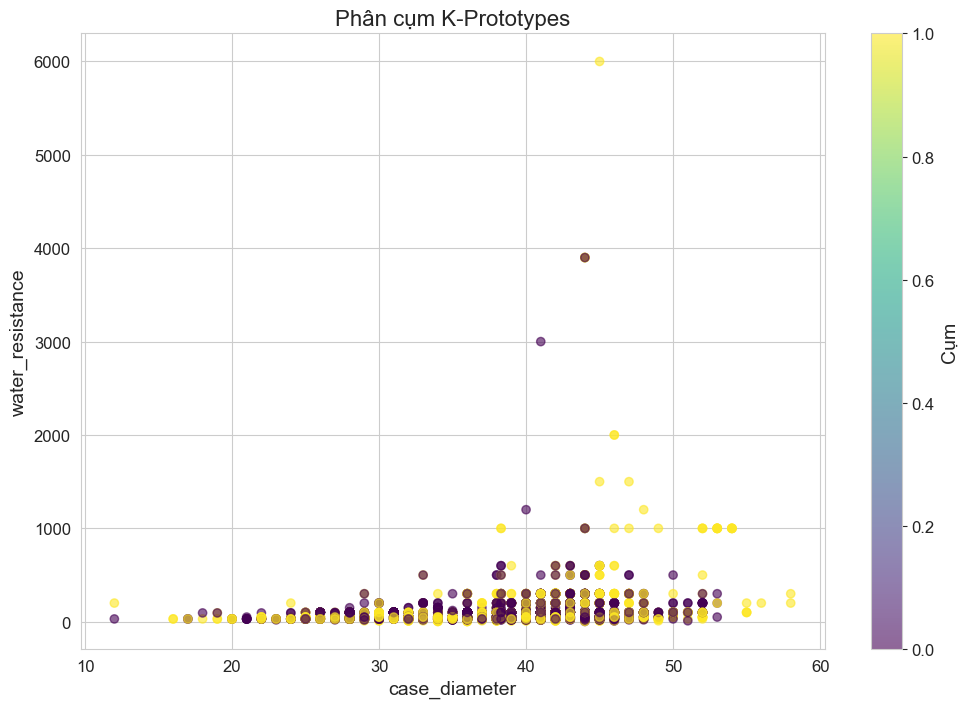

<Figure size 1000x600 with 0 Axes>

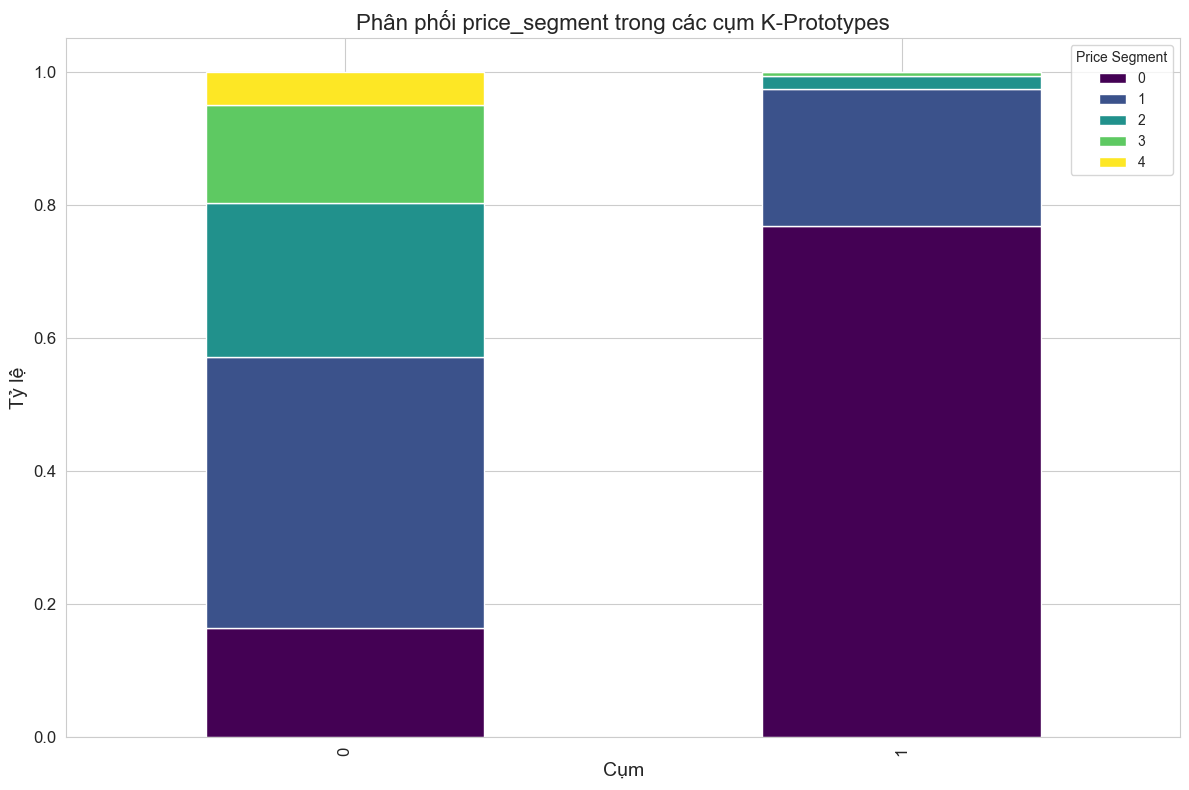

In [4]:
# K-Prototypes
print("Đang áp dụng K-Prototypes...")
kproto = KPrototypes(n_clusters=k_prototypes_n_clusters, random_state=42)
kproto_clusters = kproto.fit_predict(df_kproto, categorical=[df_kproto.columns.get_loc(col) for col in categorical_cols])
print("K-Prototypes Clusters:", np.unique(kproto_clusters, return_counts=True))

# Thêm kết quả phân cụm vào DataFrame gốc
df_original['kproto_cluster'] = kproto_clusters

# Phân tích đặc điểm của các cụm
print("\n=== ĐẶC ĐIỂM CỦA CÁC CỤM K-PROTOTYPES ===")
for cluster in range(k_prototypes_n_clusters):
    print(f"\nCụm {cluster}:")
    cluster_data = df_original[df_original['kproto_cluster'] == cluster]
    
    # Thống kê về các đặc trưng số
    print("Đặc trưng số:")
    print(cluster_data[numerical_cols].mean())
    
    # Thống kê về phân khúc giá
    print("\nPhân phối price_segment:")
    print(cluster_data['price_segment'].value_counts(normalize=True))
    
    # Top thương hiệu phổ biến nhất
    print("\nTop 3 thương hiệu phổ biến nhất:")
    print(cluster_data['brand'].value_counts().nlargest(3))

# Trực quan hóa phân cụm
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_original['case_diameter'], df_original['water_resistance'], 
                     c=df_original['kproto_cluster'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Cụm')
plt.xlabel('case_diameter')
plt.ylabel('water_resistance')
plt.title('Phân cụm K-Prototypes')
plt.grid(True)
plt.show()

# Phân tích mối quan hệ giữa các cụm và price_segment
plt.figure(figsize=(10, 6))
cluster_price = pd.crosstab(df_original['kproto_cluster'], df_original['price_segment'], normalize='index')
cluster_price.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Phân phối price_segment trong các cụm K-Prototypes')
plt.xlabel('Cụm')
plt.ylabel('Tỷ lệ')
plt.legend(title='Price Segment')
plt.tight_layout()
plt.show()

